In [2]:
#%matplotlib qt
%matplotlib inline
import os
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
import json
import torchtext
import torch.nn as nn
import nltk
import pandas as pd
nltk.download('punkt')
cmap = plt.get_cmap('viridis')
from mpl_toolkits.mplot3d import Axes3D

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
import os
rootdir = '/home/stephane/automatic-data-generation/automatic_data_generation/'
dataroot= rootdir + 'data/'
os.chdir(rootdir)

# Analyzing the runs

In [59]:
def anneal_fn(anneal_function, step, k, x, m):
    if anneal_function == 'logistic':
        return m*float(1/(1+np.exp(-k*(step-x))))
    elif anneal_function == 'linear':
        return m*min(1, step/x)
anneal_fn = np.vectorize(anneal_fn)

In [60]:
import torch
run = torch.load('../run.pkl')

In [61]:
run['args']['kl_anneal_rate']

0.01

## Dynamics

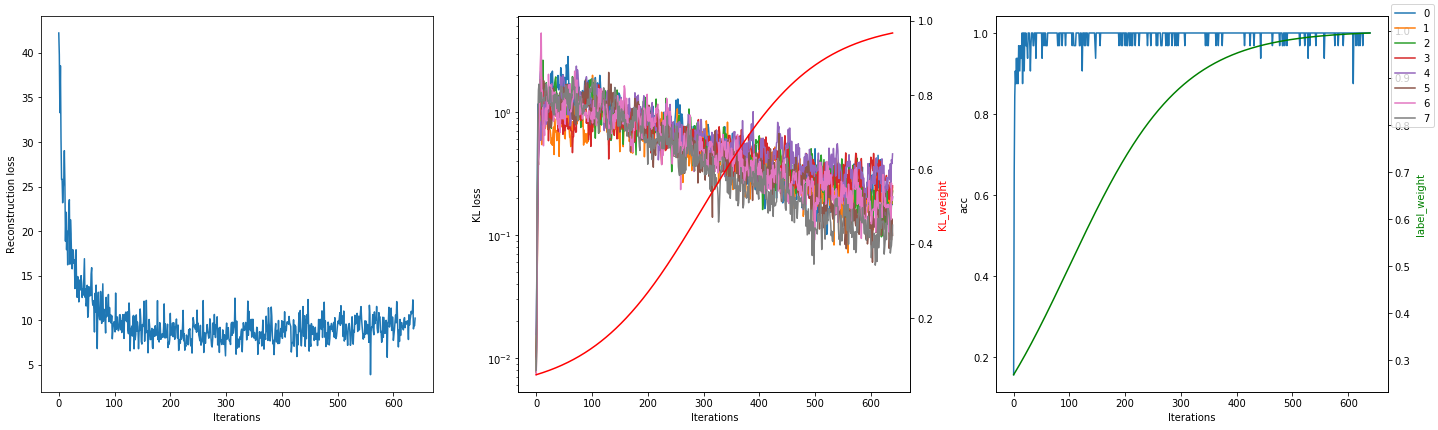

In [62]:
fig, axarr = plt.subplots(1,3, figsize=(20,6))
axarr = axarr.flatten()

args = run['args']
NLL_hist = run['logs']['train']['recon_loss']
KL_hist  = run['logs']['train']['kl_losses' ]
acc_hist = run['logs']['train']['conditioning_accuracy']
t = np.array(range(len(NLL_hist)))

KL_weight    = anneal_fn(args['annealing_strategy'], t, args['kl_anneal_rate'], args['kl_anneal_time'], args['kl_anneal_target'])
label_weight = anneal_fn(args['annealing_strategy'], t, args['label_anneal_rate'], args['label_anneal_time'], args['label_anneal_target'])

KL_hist = np.array(KL_hist)
axarr[0].plot(t, NLL_hist )
for i in range(args['latent_size']):
    axarr[1].semilogy(t, KL_hist[i], label=i)
ax1bis = axarr[1].twinx()
ax1bis.plot(t, KL_weight, color='red')
axarr[2].plot(t, acc_hist )
ax2bis = axarr[2].twinx()
ax2bis.plot(t, label_weight, color='green')

for i in range(3):
    axarr[i].set_xlabel('Iterations')
axarr[0].set_ylabel('Reconstruction loss')
axarr[1].set_ylabel('KL loss')
ax1bis.set_ylabel('KL_weight', color='red')
axarr[2].set_ylabel('acc')
ax2bis.set_ylabel('label_weight', color='green')

fig.legend()
fig.tight_layout()
plt.show()

In [55]:
n_per_intent = 20

latent = run['latent_rep']
print(latent[0])
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
all_latent = sum([latent_list for latent_list in latent.values()], [])
pca.fit(all_latent)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for intent in latent.keys():
    points = pca.transform(latent[intent])
    #points = np.array(latent[intent])
    ax.scatter(points[:n_per_intent,0], points[:n_per_intent,1], points[:n_per_intent,2], c=[cmap(intent/len(latent.keys()))], label='{}'.format(intent))
fig.legend()
plt.show()

[]


ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

## Embeddings

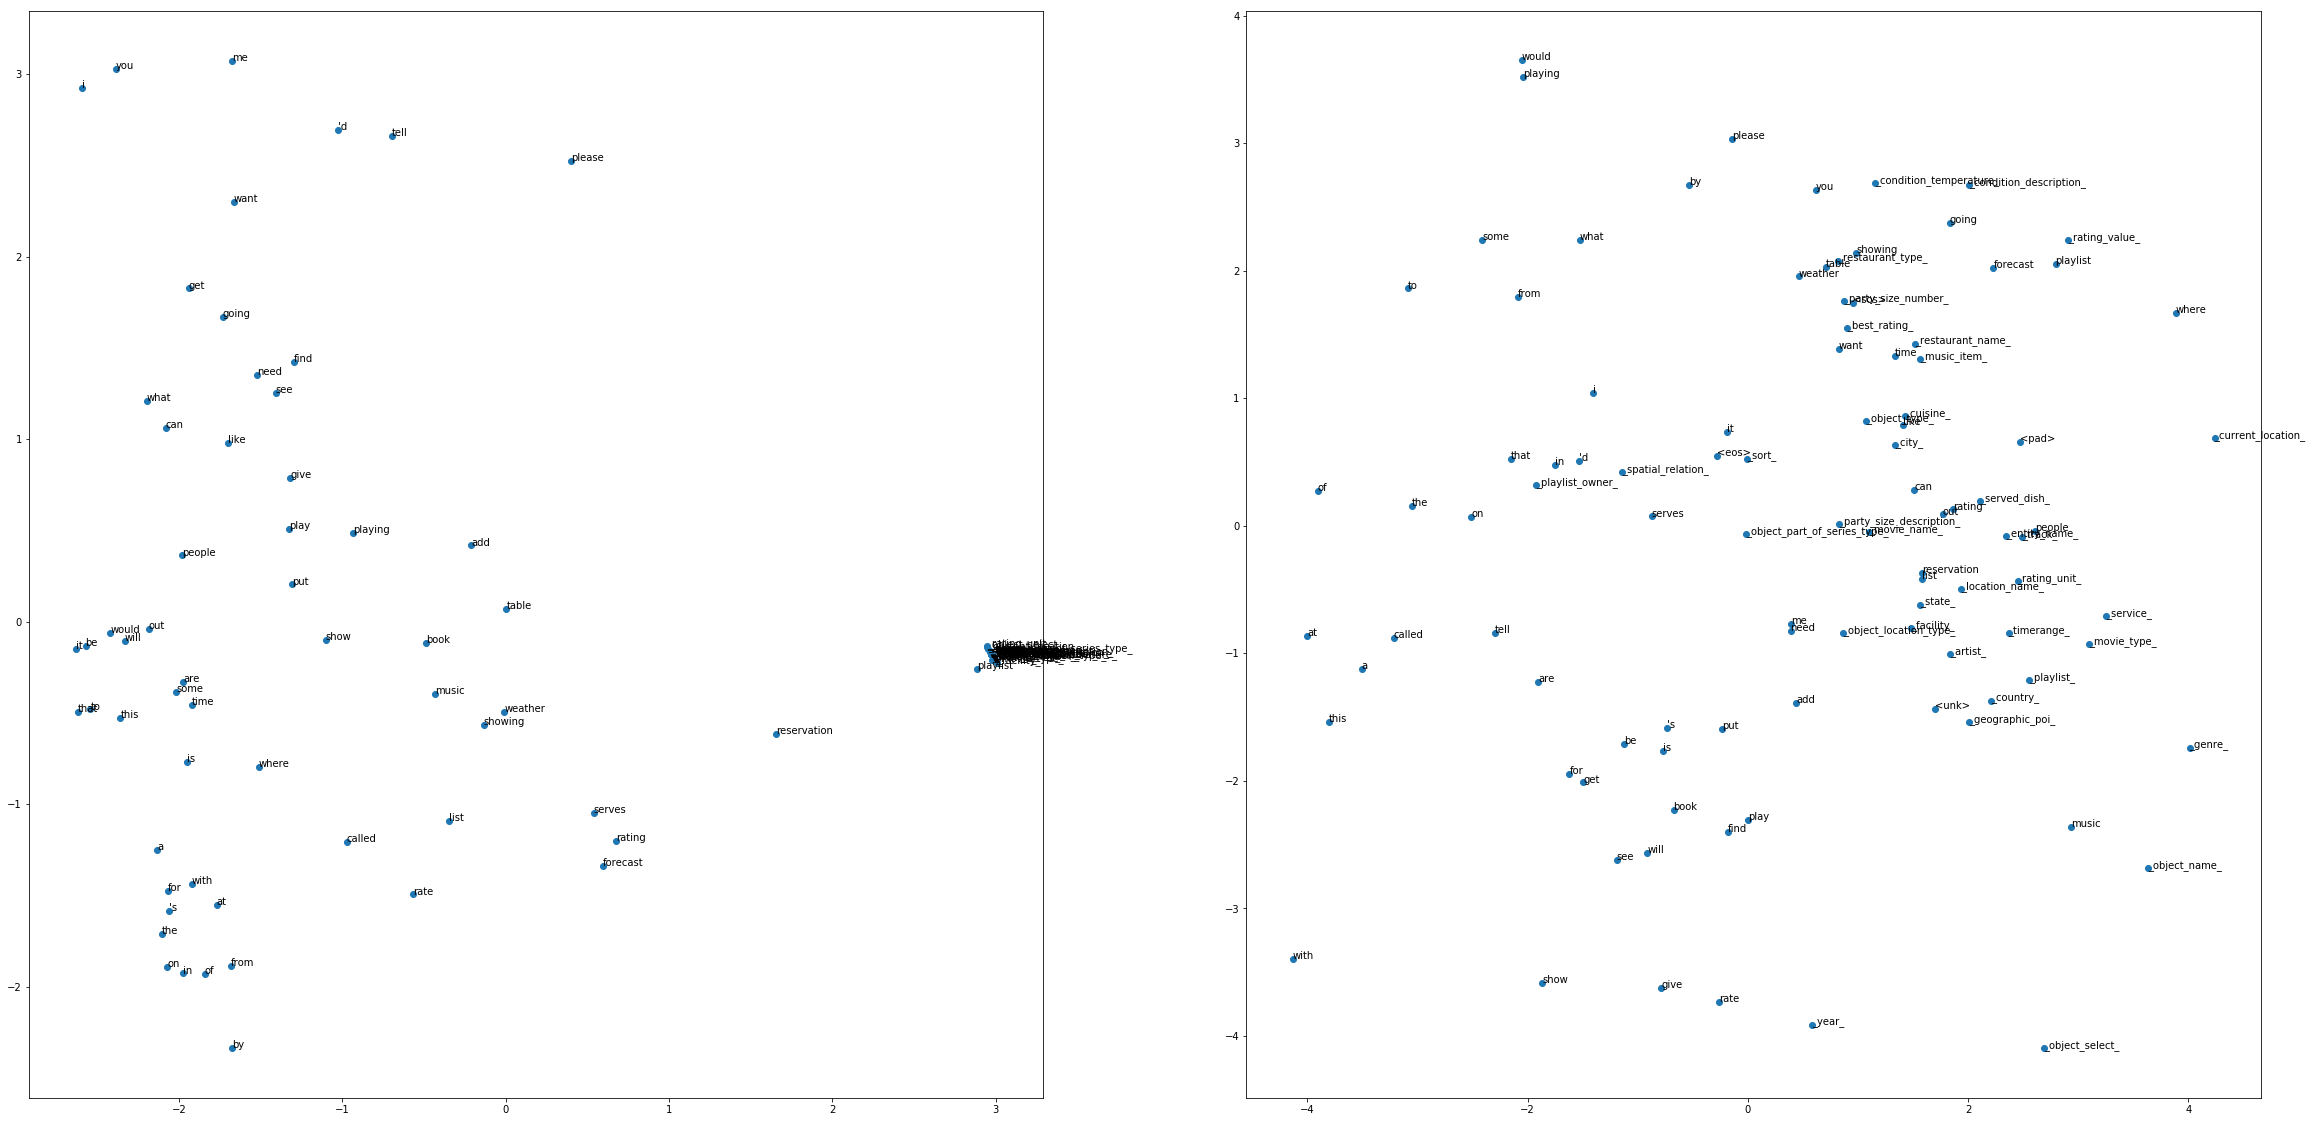

In [56]:
n_start = 0
n_end = 100
words = run['i2w']

fig, axarr = plt.subplots(1, 2, figsize=(40,20))
axarr = axarr.flatten()

from sklearn.decomposition import PCA
for ax, stage in enumerate(['before', 'after']):
    vectors = run['vectors'][stage]
    pca = PCA(n_components=2)
    proj = pca.fit_transform(vectors.cpu())
    axarr[ax].scatter(proj[n_start:n_end,0], proj[n_start:n_end,1])
    for i, word in enumerate(words[n_start:n_end]):
        i += n_start
        axarr[ax].annotate(word,xy=(proj[i,0], proj[i,1]))

## Trajectories in latent space

In [209]:
!. ./venv/bin/activate

In [458]:
from models.embedding import Datasets
from models.cvae import CVAE
from utils.utils import to_device, interpolate, idx2word

run = torch.load('run.pkl')
args = run['args']

datadir = os.path.join('./data', args.dataset)
train_path = os.path.join(datadir, 'train.csv')
validate_path = os.path.join(datadir, 'validate.csv')
datasets = Datasets(train_path=os.path.join(train_path), valid_path=os.path.join(validate_path), emb_dim=args.emb_dim, tokenizer=args.tokenizer)

if args.input_type=='delexicalised':
    print('embedding the slots with %s averaging' %args.slot_averaging)
    datasets.embed_slots(args.slot_averaging)

vocab = datasets.TEXT.vocab if args.input_type=='utterance' else datasets.DELEX.vocab
i2w = vocab.itos
w2i = vocab.stoi
i2int = datasets.INTENT.vocab.itos
int2i = datasets.INTENT.vocab.stoi
n_classes = len(i2int)
sos_idx = w2i['<sos>']
eos_idx = w2i['<eos>']
pad_idx = w2i['<pad>']
unk_idx = w2i['<unk>']

model = CVAE(
        vocab_size=len(i2w),
        max_sequence_length=args.max_sequence_length,
        sos_idx=sos_idx,
        eos_idx=eos_idx,
        pad_idx=pad_idx,
        unk_idx=unk_idx,
        embedding_size=args.emb_dim,
        rnn_type=args.rnn_type,
        hidden_size=args.hidden_size,
        word_dropout=args.word_dropout,
        embedding_dropout=args.embedding_dropout,
        z_size=args.latent_size,
        n_classes=n_classes,
        num_layers=args.num_layers,
        bidirectional=args.bidirectional,
        temperature=args.temperature,
        conditional=False if args.conditional=='none' else True,
        bow=args.bow_loss
    )

state_dict = torch.load(args.pickle+'.pyT')
if state_dict['embedding.weight'].size(0) != model.embedding.weight.size(0): # vocab changed
    state_dict['embedding.weight'] = vocab.vectors
    state_dict['outputs2vocab.weight'] = torch.randn(len(i2w), args.hidden_size*model.hidden_factor)
    state_dict['outputs2vocab.bias'] = torch.randn(len(i2w))
model.load_state_dict(state_dict)

print('BLEU : ',run['bleu_scores'])
print('Diversity : ',run['diversity'])

ModuleNotFoundError: No module named 'automatic_data_generation'

In [63]:
i2int

['GetWeather',
 'PlayMusic',
 'BookRestaurant',
 'SearchScreeningEvent',
 'RateBook',
 'SearchCreativeWork',
 'AddToPlaylist']

### Vary the continuous variable

In [463]:
for i, intent in enumerate(i2int):
    
    interp_dim = 1
    print(intent)

    #z1 = torch.randn([args.latent_size]).numpy()
    #z2 = torch.randn([args.latent_size]).numpy()
    z1 = torch.zeros([args.latent_size]).numpy()
    z2 = torch.zeros([args.latent_size]).numpy()
    z1[interp_dim] = -5
    z2[interp_dim] = +5
    z = to_device(torch.from_numpy(interpolate(start=z1, end=z2, steps=10)).float())
    batch_size=z.size(0)

    y_onehot = torch.zeros(batch_size, model.n_classes)
    y = torch.LongTensor(batch_size,1).fill_(i)
    y_onehot.scatter_(1, y, 1)
    samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

    print('-------INTERPOLATIONS-------')
    print(*idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>']), sep='\n')
    print('\n')

NameError: name 'i2int' is not defined

### Vary the discrete variable

z = torch.randn(model.n_classes,args.latent_size)

y_onehot = torch.zeros(model.n_classes, model.n_classes)
for i in range(model.n_classes):
    y_onehot[i,i] = 1

samples, z, y_onehot = model.inference(z=z, y_onehot=y_onehot)

for intent, sentence in enumerate(idx2word(samples, i2w=i2w, pad_idx=w2i['<pad>'])):
    print(i2int[intent])
    print(sentence + '\n')

In [512]:
import torchtext
from nltk import word_tokenize
train_path = 'data/snips/train.csv'
valid_path = 'data/snips/validate.csv'

TEXT = torchtext.data.Field(lower=True, tokenize=word_tokenize,
                            sequential=True, batch_first=True,
                            include_lengths=True,
                            init_token='<sos>', eos_token='<eos>')
LABEL = torchtext.data.Field(lower=False, tokenize=word_tokenize,
                            sequential=True, batch_first=True,
                            include_lengths=True,
                            init_token='<sos>', eos_token='<eos>')
DELEX = torchtext.data.Field(lower=True, tokenize=word_tokenize,
                             sequential=True, batch_first=True,
                             include_lengths=True,
                             init_token='<sos>', eos_token='<eos>')
INTENT = torchtext.data.Field(sequential=False, batch_first=True,
                              unk_token=None, pad_token=None)

skip_header = True
if 'snips' in train_path:
    datafields = [("utterance", TEXT), ("labels", LABEL),
                  ("delexicalised", DELEX), ("intent", INTENT)]

train, valid = torchtext.data.TabularDataset.splits(
    path='.',  # the root directory where the data lies
    train=train_path,
    validation=valid_path,
    format='csv',
    skip_header=skip_header,
    # if your csv header has a header, make sure to pass this to
    # ensure it doesn't get proceesed as data!
    fields=datafields
)

TEXT.build_vocab(train)
LABEL.build_vocab(train)
INTENT.build_vocab(train)

In [534]:
run = torch.load('run.pkl')

dic_gen = {intent:{} for intent in run['i2int']}
for i, delex in enumerate(run['generated']['delexicalised']):
    intent = run['generated']['intents'][i]
    if delex not in dic_gen[intent]:
        dic_gen[intent][delex] = 1
    else:
        dic_gen[intent][delex] += 1
        
dic_tr = {intent:{} for intent in run['i2int']}
for i, example in enumerate(train):
    intent = example.intent
    delex = ' '.join(example.delexicalised)
    if delex not in dic_tr[intent].keys():
        dic_tr[intent][delex] = 1
    else:
        dic_tr[intent][delex] += 1   
print(i)
        
for dic in [dic_gen]:
    for intent in run['i2int']:
        dic[intent] = sorted(dic[intent].items(), key=operator.itemgetter(1))[::-1]

13783


In [532]:
intent = 'BookRestaurant'
print('{:<15} {:<15} {}\n'.format('# generated', '# in trainset', 'sentence'))
for sentence, gen_occurences in dic_gen[intent]:
    tr_occurences = dic_tr[intent][sentence] if sentence in dic_tr[intent] else 0
    print('{:<15} {:<15} {}'.format(gen_occurences, tr_occurences, sentence))

print('\n')
for dic in [dic_tr]:
    for key, val in dic[intent].items():
        if key.startswith('book a _restaurant_type_ in _city_'):
            print('{:<6} {}'.format(val, key))

# generated     # in trainset   sentence

43              6               book a _restaurant_type_ for _party_size_number_ people
43              0               i need a reservation for _party_size_number_ at a _restaurant_type_ that serves _served_dish_
17              0               book a table for _party_size_number_ at a _restaurant_type_ which serves _served_dish_
12              0               i need a table for _party_size_number_ at a _restaurant_type_ that has _served_dish_
9               0               i need a reservation for _party_size_number_ at a _restaurant_type_ that serves _served_dish_ in _city_
6               1               book a table for _party_size_number_ people at a _restaurant_type_ that serves _served_dish_
6               1               book a table for _party_size_number_ people at a _restaurant_type_ which serves _served_dish_
3               0               book a table for _party_size_number_ at a _restaurant_type_ that serves _served_dish_ in 

# Demo

In [508]:
def demo():
    
    run = torch.load('run.pkl')

    requested_intent = input('Select your intent : ')
    print('\n')
    indices = [i for i,intent in enumerate(run['generated']['intents']) if intent == requested_intent]

    print(*[run['generated']['utterances'][idx] for idx in indices], sep='\n\n')

# Grid search

In [ ]:
#results_dir = 'results_datasize_prop'
results_dir = 'results_gs_tiny'
runs = []

for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        runs.append(torch.load(os.path.join(results_dir,filename)))
        
data = {}
for arg_name in runs[0]['args'].__dict__.keys():
    data[arg_name] = [getattr(run['args'], arg_name) for run in runs]
data['bleu_quality']   = np.array([run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs])
data['bleu_diversity'] = np.array([run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs])
data['accuracy']       = np.array([run['delexicalised_metrics']['intent_accuracy'] for run in runs])
data['raw']            = np.array([run['metrics']['improvement']['raw_acc'] for run in runs])
data['aug']            = np.array([run['metrics']['improvement']['aug_acc'] for run in runs])

data['metric'] = data['bleu_quality'] * data['bleu_diversity'] * data['accuracy']

df = pd.DataFrame(data, columns=['datasize', 'epochs', 'x1', 'x2', 'k1', 'k2', 
                                 'latent_size', 'hidden_size', 'num_layers', 'embedding_dropout', 'emb_dim', 'learning_rate', 'temperature',
                                 'bleu_quality', 'bleu_diversity', 'accuracy', 'raw', 'aug', 'metric'])
df = df.sort_values(by = 'metric', ascending=False)
df.head(100)

In [ ]:
irun = np.argmax(data['metric'])
print(irun)
run = runs[irun]
list(zip(run['generated']['intents'], runs[irun]['generated']['utterances']))[:10]

In [ ]:
datasizes        = [run['args'].datasize for run in runs]
bleu_qualities   = [run['metrics']['bleu_scores']['quality']['avg'] for run in runs]
bleu_diversities = [run['metrics']['bleu_scores']['diversity']['avg'] for run in runs]
org_bleu_diversities = [run['metrics']['bleu_scores']['original_diversity']['avg'] for run in runs]
diversities      = [run['metrics']['diversity'] for run in runs]
entropies     = [run['metrics']['entropy'] for run in runs]
accuracies       = [run['metrics']['intent_accuracy'] for run in runs]
raw          = [run['metrics']['improvement']['raw_acc'] for run in runs]
augmented    = [run['metrics']['improvement']['aug_acc'] for run in runs]
se_augmented = [run['slot_expansion_metrics']['improvement']['aug_acc'] for run in runs]

delex_bleu_qualities   = [run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs]
delex_bleu_diversities = [run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
org_delex_bleu_diversities = [run['metrics']['bleu_scores']['original_diversity']['avg'] for run in runs]
delex_diversities      = [run['delexicalised_metrics']['diversity'] for run in runs]
delex_accuracies       = [run['delexicalised_metrics']['intent_accuracy'] for run in runs]

se_bleu_qualities   = [run['slot_expansion_metrics']['bleu_scores']['quality']['avg'] for run in runs]
se_bleu_diversities = [run['slot_expansion_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
se_diversities      = [run['slot_expansion_metrics']['diversity'] for run in runs]
se_accuracies       = [run['slot_expansion_metrics']['intent_accuracy'] for run in runs]

fig, axarr = plt.subplots(2,3, figsize=(14,7))
axarr = axarr.flatten()

axarr[0].scatter(datasizes, augmented, label='Augmented'                ,alpha=0.5)
axarr[0].scatter(datasizes, se_augmented, label='Slot Expansion'        ,alpha=0.5)
axarr[0].scatter(datasizes, raw, label='Raw'                            ,alpha=0.5)
axarr[1].scatter(datasizes, bleu_qualities     ,label='Augmented'     ,alpha=0.5)
axarr[1].scatter(datasizes, se_bleu_qualities  ,label='Slot Expansion'  ,alpha=0.5)
axarr[1].scatter(datasizes, delex_bleu_qualities  ,label='Delexicalised',alpha=0.5)
axarr[2].scatter(datasizes, accuracies         ,label='Augmented'     ,alpha=0.5)
axarr[2].scatter(datasizes, se_accuracies      ,label='Slot Expansion'  ,alpha=0.5)
axarr[2].scatter(datasizes, delex_accuracies      ,label='Delexicalised',alpha=0.5)
#axarr[3].scatter(datasizes, org_bleu_diversities,label='Original',alpha=0.5)
#axarr[3].scatter(datasizes, bleu_diversities   ,label='Augmented'     ,alpha=0.5)
#axarr[3].scatter(datasizes, se_bleu_diversities,label='Slot Expansion'  ,alpha=0.5)
axarr[3].scatter(datasizes, delex_bleu_diversities,label='Delexicalised',alpha=0.5)
axarr[3].scatter(datasizes, org_delex_bleu_diversities,label='Original delexicalised',alpha=0.5)
axarr[4].scatter(datasizes, diversities        ,label='Augmented'     ,alpha=0.5)
axarr[4].scatter(datasizes, se_diversities     ,label='Slot Expansion'  ,alpha=0.5)
axarr[4].scatter(datasizes, delex_diversities     ,label='Delexicalised',alpha=0.5)
axarr[5].scatter(datasizes, entropies                                   )

axarr[0].set_ylabel('Intent classif improvement ')
axarr[1].set_ylabel('BLEU quality')
axarr[2].set_ylabel('Intent accuracy')
axarr[3].set_ylabel('BLEU diversity')
axarr[4].set_ylabel('Diversity')
axarr[5].set_ylabel('Entropy')
for ax in axarr:
    ax.set_xscale('log')
    ax.set_xlabel('Train data size')
    ax.legend()

fig.tight_layout()

# Transfer from a None class

python -m grid results_transfer "python automatic_data_generation/train_and_eval_cvae.py -ep 50 --dataset-size 70 --none-type yelp" --none-size:int 0 10 20 50 100 200 500 1000 --n_parallel 1

In [13]:
#results_dir = 'results_datasize_prop'
results_dir = '../results_transfer'
runs = []

for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        runs.append(torch.load(os.path.join(results_dir,filename)))
        
runs.sort(key = lambda x : x['args']['none_size'])
runs.sort(key = lambda x : x['args']['none_type'])
#runs.sort(key = lambda x : x['args']['none_size'])

data = {}
for arg_name in runs[0]['args'].keys():
    data[arg_name] = [run['args'][arg_name] for run in runs]
data['bleu_quality']   = np.array([run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs])
data['bleu_diversity'] = np.array([run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs])
data['accuracy']       = np.array([run['delexicalised_metrics']['intent_accuracy'] for run in runs])

    
df = pd.DataFrame(data, columns=['dataset_size', 'n_epochs', 'none_size', 'none_type'])
print(df.head(30))

runs = [run for run in runs if (run['args']['none_type']=='yelp') and (run['args']['dataset_size']==70)]

    dataset_size  n_epochs  none_size  none_type
0             70        50          0  subtitles
1             70        50         10  subtitles
2             70        50         20  subtitles
3             70        50         50  subtitles
4             70        50        100  subtitles
5             70        50        200  subtitles
6             70        50        500  subtitles
7             70        50       1000  subtitles
8             70        50          0       yelp
9            700        50          0       yelp
10            70        50          0       yelp
11           700        50         10       yelp
12            70        50         10       yelp
13            70        50         20       yelp
14           700        50         20       yelp
15           700        50         50       yelp
16            70        50         50       yelp
17            70        50        100       yelp
18           700        50        100       yelp
19            70    

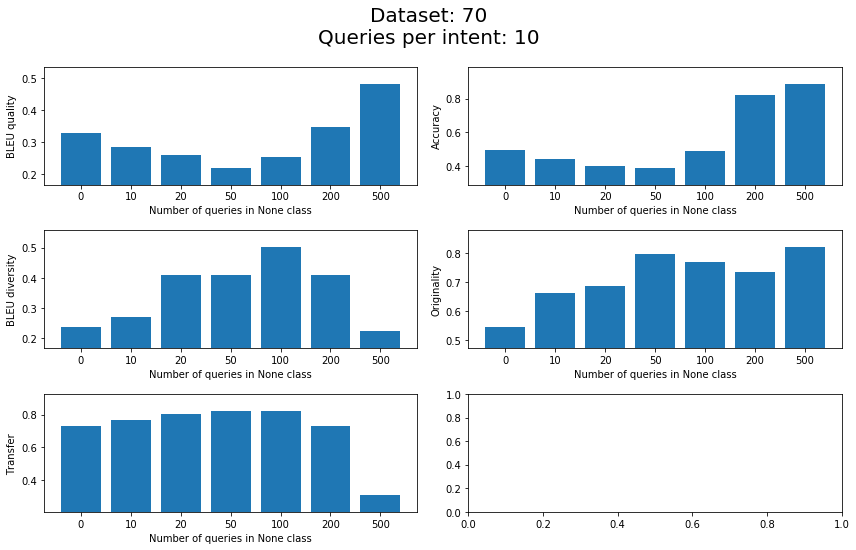

In [16]:
none_sizes = [str(run['args']['none_size']) for run in runs]

intents = runs[0]['delexicalised_metrics']['bleu_scores']['quality'].keys()

#bleu_qualities     = [np.mean([    run['delexicalised_metrics']['bleu_scores']['quality'][intent] for intent in intents if intent!='None']) for run in runs]
bleu_qualities     = [run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in runs]
accuracies         = [run['delexicalised_metrics']['intent_accuracy'] for run in runs]
bleu_diversities   = [run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in runs]
bleu_originalities = [run['delexicalised_metrics']['originality']['avg'] for run in runs]
transfer           = [run['delexicalised_metrics']['transfer']['avg'] for run in runs]
metrics = [bleu_qualities, accuracies, bleu_diversities, bleu_originalities, transfer]

accuracies
fig, axarr = plt.subplots(3,2, figsize=(12,8))
axarr = axarr.flatten()

for i, metric in enumerate(metrics):

    axarr[i].bar(none_sizes, metric )
    low, high, delta = min(metric), max(metric), max(metric) - min(metric)
    axarr[i].set_ylim(low - 0.2 * delta, high + 0.2 * delta)
    axarr[i].set_xlabel('Number of queries in None class')

axarr[0].set_ylabel('BLEU quality'  )
axarr[1].set_ylabel('Accuracy'      )
axarr[2].set_ylabel('BLEU diversity')
axarr[3].set_ylabel('Originality'   )
axarr[4].set_ylabel('Transfer'   )

fig.suptitle('Dataset: {}\nQueries per intent: {}'.format(runs[0]['args']['dataset_size'], int(runs[0]['args']['dataset_size']/7)), fontsize=20)

fig.tight_layout(rect=[0, 0.03, 1, 0.9])

In [ ]:
run = runs[2]
requested_intent = 'PlayMusic'
indices = [i for i,intent in enumerate(run['generated']['intents']) if intent == requested_intent]
print(*[run['generated']['delexicalised'][idx] for idx in indices], sep='\n\n')

# One vs all

python -m grid results_onevsall_140 "python automatic_data_generation/train_and_eval_cvae.py -ep 100 --dataset-size 20 --n-generated 1000" --restrict-to-intent:str PlayMusic GetWeather RateBook BookRestaurant AddToPlaylist SearchScreeningEvent SearchCreativeWork --n_parallel 1

In [28]:
results_dir = '../results_onevsall_140'
runs = []

for filename in os.listdir(results_dir):
    if filename.endswith('.pkl'):
        runs.append(torch.load(os.path.join(results_dir,filename)))
    
data = {}
for arg_name in runs[0]['args'].keys():
    data[arg_name] = [run['args'][arg_name] for run in runs]

vae_runs = [run for run in runs if run['args']['restrict_to_intent'] is not None]
cvae_run = [run for run in runs if run['args']['restrict_to_intent'] is None][0]
    
df = pd.DataFrame(data, columns=['pickle', 'dataset_size', 'n_generated', 'n_epochs', 'restrict_to_intent'])
df.head(20)

,pickle,dataset_size,n_generated,n_epochs,restrict_to_intent
0,results_onevsall_140/34530.pkl,20,1000,100,[GetWeather]
1,results_onevsall_140/46491.pkl,20,1000,100,[PlayMusic]
2,results_onevsall_140/14927.pkl,20,1000,100,[SearchScreeningEvent]
3,results_onevsall_140/39789.pkl,20,1000,100,[AddToPlaylist]
4,results_onevsall_140/46017.pkl,20,1000,100,[RateBook]
5,results_onevsall_140/36307.pkl,20,1000,100,[BookRestaurant]
6,results_onevsall_140/16940.pkl,140,1000,100,None
7,results_onevsall_140/41026.pkl,20,1000,100,[SearchCreativeWork]


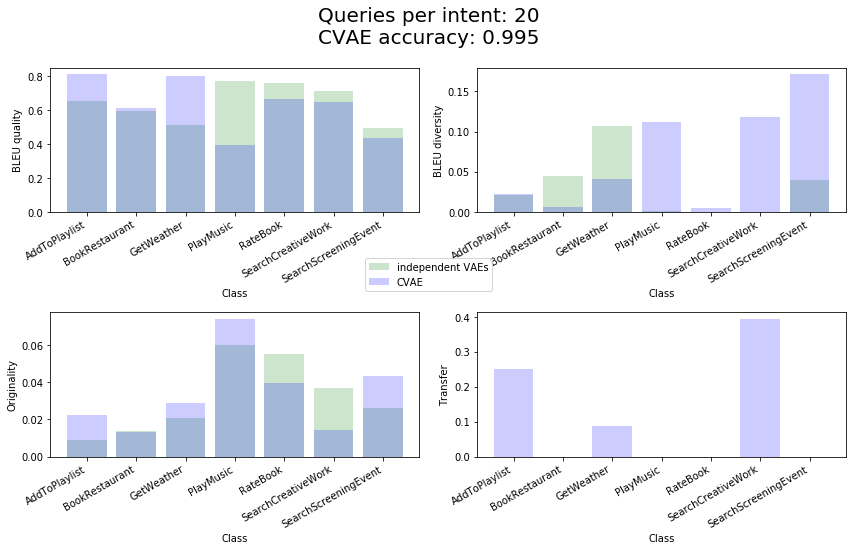

In [29]:
fig, axarr = plt.subplots(2,2, figsize=(12,8))
axarr = axarr.flatten()

restrict = sorted([str(run['args']['restrict_to_intent'][0]) for run in vae_runs])

bleu_qualities     = [run['delexicalised_metrics']['bleu_scores']['quality']['avg'] for run in vae_runs]
bleu_diversities   = [run['delexicalised_metrics']['bleu_scores']['diversity']['avg'] for run in vae_runs]
originalities      = [run['delexicalised_metrics']['originality']['avg'] for run in vae_runs]
#transfer           = [run['delexicalised_metrics']['transfer']['avg'] for run in runs]
metrics = [bleu_qualities, bleu_diversities, originalities]

for i, metric in enumerate(metrics):
    axarr[i].bar(restrict, metric, alpha=0.2, color='green', label='independent VAEs' if i==0 else '')
    for label in axarr[i].get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")
    low, high, delta = min(metric), max(metric), max(metric) - min(metric)
    #axarr[i].set_ylim(low - 0.2 * delta, high + 0.2 * delta)
    axarr[i].set_xlabel('Class')

bleu_qualities     = [cvae_run['delexicalised_metrics']['bleu_scores']['quality'][intent] for intent in restrict]
bleu_diversities   = [cvae_run['delexicalised_metrics']['bleu_scores']['diversity'][intent] for intent in restrict]
originalities      = [cvae_run['delexicalised_metrics']['originality'][intent] for intent in restrict]
transfer           = [cvae_run['delexicalised_metrics']['transfer'][intent] for intent in restrict]
metrics = [bleu_qualities, bleu_diversities, originalities, transfer]

for i, metric in enumerate(metrics):

    axarr[i].bar(restrict, metric, alpha=0.2, color='blue', label='CVAE' if i==0 else '')
    for label in axarr[i].get_xmajorticklabels():
        label.set_rotation(30)
        label.set_horizontalalignment("right")
    low, high, delta = min(metric), max(metric), max(metric) - min(metric)
    #axarr[i].set_ylim(low - 0.2 * delta, high + 0.2 * delta)
    axarr[i].set_xlabel('Class')

axarr[0].set_ylabel('BLEU quality'  )
axarr[1].set_ylabel('BLEU diversity')
axarr[2].set_ylabel('Originality'   )
axarr[3].set_ylabel('Transfer'   )

fig.suptitle('Queries per intent: {}\nCVAE accuracy: {}'.format(vae_runs[0]['args']['dataset_size'], cvae_run['delexicalised_metrics']['intent_accuracy']), fontsize=20)
fig.legend(loc='center')

fig.tight_layout(rect=[0, 0.03, 1, 0.9])